## SVM and PCA Model

In [ ]:
import os
import shutil
import random
from zipfile import ZipFile
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, roc_curve, auc,
    classification_report, confusion_matrix, ConfusionMatrixDisplay
)


In [ ]:
# 1. Unzip dataset if uploaded as dataset.zip
zip_path = "/content/dataset.zip"
extract_dir = "/content/dataset"

if os.path.exists(zip_path):
    with ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)

# 2. Load images
img_size = (128, 128)
X, y = [], []

for label in ['First Print', 'Second Print']:
    class_dir = os.path.join(extract_dir, label)
    for img_file in os.listdir(class_dir):
        if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(class_dir, img_file)
            img = load_img(img_path, color_mode='grayscale', target_size=img_size)
            img_array = img_to_array(img).flatten()
            X.append(img_array)
            y.append(label)

X = np.array(X)
y = LabelEncoder().fit_transform(y)

# 3. Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


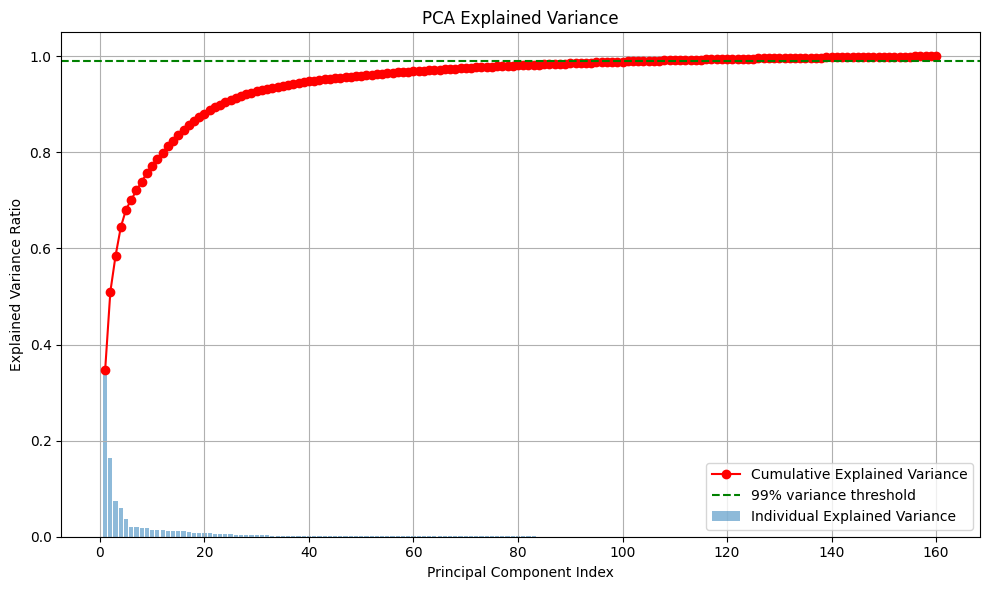

In [ ]:

pca = PCA()
pca.fit(X_train)

explained_var = pca.explained_variance_ratio_
cum_var = np.cumsum(explained_var)

plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_var)+1), explained_var, alpha=0.5, label='Individual Explained Variance')
plt.plot(range(1, len(cum_var)+1), cum_var, marker='o', color='r', label='Cumulative Explained Variance')
plt.axhline(y=0.99, color='g', linestyle='--', label='99% variance threshold')
plt.xlabel('Principal Component Index')
plt.ylabel('Explained Variance Ratio')
plt.legend()
plt.title('PCA Explained Variance')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:


# Keep components that explain 99% variance
n_components = np.argmax(cum_var >= 0.99) + 1
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Initialize and train SVM on full training set
svm = SVC(kernel='rbf', probability=True, tol=1e-6)
svm.fit(X_train_pca, y_train)

# Predictions on train/test
y_train_pred = svm.predict(X_train_pca)
y_test_pred = svm.predict(X_test_pca)
y_test_proba = svm.predict_proba(X_test_pca)[:, 1]

# Accuracy scores
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)
print(f"Train Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

# Apply PCA to full dataset for cross-validation
X_pca = pca.transform(X)

# Cross-validation: Accuracy & Loss
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_accuracies = []
cv_losses = []

for fold, (train_idx, test_idx) in enumerate(kfold.split(X_pca, y), start=1):
    X_tr, X_te = X_pca[train_idx], X_pca[test_idx]
    y_tr, y_te = y[train_idx], y[test_idx]

    fold_svm = SVC(kernel='rbf', probability=True, tol=1e-6)
    fold_svm.fit(X_tr, y_tr)
    y_pred = fold_svm.predict(X_te)

    acc = accuracy_score(y_te, y_pred)
    loss = 1 - acc  # pseudo loss

    cv_accuracies.append(acc)
    cv_losses.append(loss)


Train Accuracy: 0.9688
Test Accuracy: 0.9500


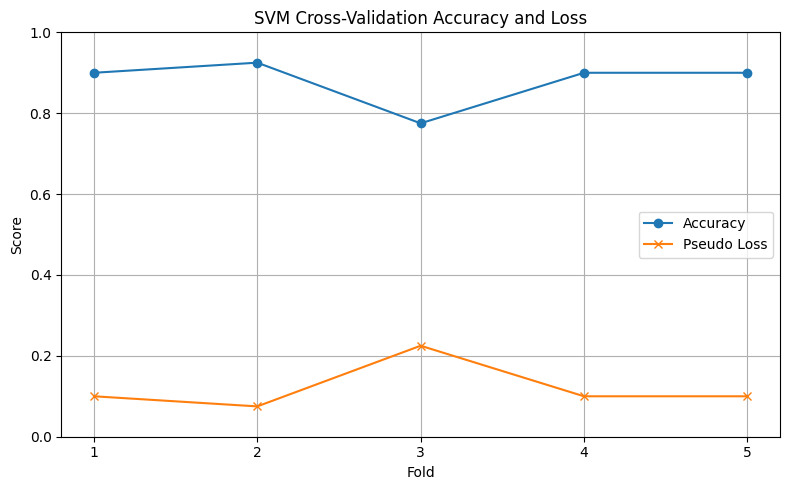

In [ ]:

# Plot Accuracy and Loss per fold
plt.figure(figsize=(8, 5))
plt.plot(range(1, 6), cv_accuracies, marker='o', label='Accuracy')
plt.plot(range(1, 6), cv_losses, marker='x', label='Pseudo Loss')
plt.xlabel('Fold')
plt.ylabel('Score')
plt.title('SVM Cross-Validation Accuracy and Loss')
plt.xticks(range(1, 6))
plt.ylim(0, 1)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:


report = classification_report(y_test, y_test_pred, target_names=['First Print', 'Second Print'])
print(report)


              precision    recall  f1-score   support

 First Print       1.00      0.86      0.92        21
Second Print       0.86      1.00      0.93        19

    accuracy                           0.93        40
   macro avg       0.93      0.93      0.92        40
weighted avg       0.94      0.93      0.92        40



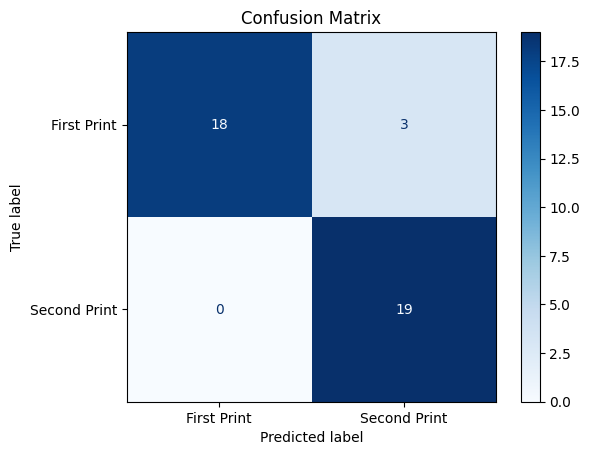

In [ ]:
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['First Print', 'Second Print'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()


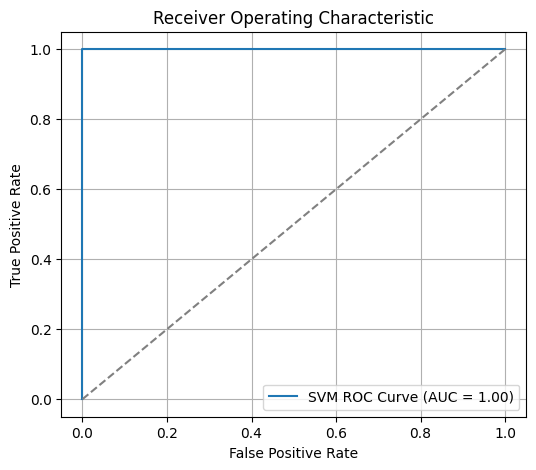

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'SVM ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend()
plt.grid(True)
plt.show()
